### Set-up

Adapted from [this Kaggle notebook](https://www.kaggle.com/code/vincentmaladiere/pytorch-resnet18-0-93) and from Indu Panigrahi's and Carlos Jimenez's Princeton AI4ALL sessions.

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
!gdown https://drive.google.com/uc?id=1rD8NzCsUJbuUyH-b6zDylp8m4ZVPY9lH -O amazon-dataset-split-all.tar.gz
!gdown https://drive.google.com/uc?id=1Qpdhlky4uaMBj4kvsKnFWD1nAsEaI5UH -O train_classes.csv
!tar -xzf amazon-dataset-split-all.tar.gz && rm -f amazon-dataset-split-all.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1rD8NzCsUJbuUyH-b6zDylp8m4ZVPY9lH
To: /content/amazon-dataset-split-all.tar.gz
100% 630M/630M [00:08<00:00, 72.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qpdhlky4uaMBj4kvsKnFWD1nAsEaI5UH
To: /content/train_classes.csv
100% 1.43M/1.43M [00:00<00:00, 30.3MB/s]


In [ ]:
import os
import random
from time import time
import pandas as pd
import numpy as np # for numerical operations, super useful for dealing with arrays/matrices
from tqdm.notebook import tqdm
import pickle # for storing information into pickle files

# for visualization
from plotly import graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# for the scores and confusion matrices
from sklearn.metrics import fbeta_score, confusion_matrix

# for visualization
from matplotlib import pyplot as plt
%matplotlib inline

import cv2

# PyTorch imports: useful for anything to do with our model
# (i.e., the model itself, loading the data into the model, etc,)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
!pip install -q torchsummary --user
from torchsummary import summary

### Load CLIP

In [ ]:
import clip
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_encoder, preprocess = clip.load('ViT-B/32', device)

### Rainforest Data

In [ ]:
import os

# checking how much training and validation data we have
train_paths = ["amazon-dataset-split-all/train", ]
val_paths = ["amazon-dataset-split-all/validation", ]
num_train = sum([len(os.listdir(path)) for path in train_paths])
num_val = sum([len(os.listdir(path)) for path in val_paths])
print(
    f"train files: {num_train}, "
    f"validation files: {num_val}"
)

train files: 32370, validation files: 8109


In [ ]:
import pandas as pd

# taking a quick look at our training data
path_class = os.path.join("train_classes.csv") # original is train_classes.csv
df_class = pd.read_csv(path_class)
df_class = df_class
df_class.head()
df_class["list_tags"] = df_class.tags.str.split(" ")

In [ ]:
# another helper function for loading data information
def load_split(paths, df_class):
    if isinstance(paths, str):
        paths = [paths]
    elif not isinstance(paths, (list, tuple, set)):
        raise ValueError('Expected type in {list, tuple, set, str} but got ' + str(type(paths)))
    image_names = list()
    for path in paths:
        image_names += list(map(lambda x: x.split('.', 1)[0], os.listdir(path)))
    return df_class[df_class.image_name.map(lambda x: x in image_names)].reset_index(drop=True)

In [ ]:
# the possible labels for our dataset
LABEL_IDXS = {
    'agriculture': 0,
    'artisinal_mine': 1,
    'bare_ground': 2,
    'blooming': 3,
    'blow_down': 4,
    'clear': 5,
    'cloudy': 6,
    'conventional_mine': 7,
    'cultivation': 8,
    'habitation': 9,
    'haze': 10,
    'partly_cloudy': 11,
    'primary': 12,
    'road': 13,
    'selective_logging': 14,
    'slash_burn': 15,
    'water': 16,
}
INVERSE_LABEL_IDXS = {v: k for k, v in LABEL_IDXS.items()}

# converts the parameter tag_list (list of words, subset of the keys in LABEL_IDXS) to a one-hot encoding
def transform_targets(tag_list):
    targets = np.zeros(len(LABEL_IDXS), dtype=np.int8)
    mask = [LABEL_IDXS[tag] for tag in tag_list]
    targets[mask] = 1
    # returns list of ones and zeros
    # (e.g. tag_list = ['primary', 'haze'] -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
    return targets.tolist()

# converts the parameter targets (one-hot encoding) back into a list of tags (subset of words from LABEL_IDXS)
def inverse_transform_targets(targets):
    idxs = [idx for idx, target in enumerate(targets) if target]
    tag_list = [INVERSE_LABEL_IDXS[ix] for ix in idxs]
    return list(sorted(tag_list))

In [ ]:
from torch.utils.data import DataLoader, Dataset
import cv2
import matplotlib.pyplot as plt
from PIL import Image

class AmazonDataset(Dataset):
    # basically defines what information we store for a dataset
    def __init__(
        self,
        df,
        transform,
        paths,
        is_train=True,
        idx_tta=None,
    ):
        super().__init__()
        self.df = df
        self.ohe_tags = list(map(transform_targets, self.df.list_tags.values))
        self.transform = transform
        if isinstance(paths, str):
            self.paths = [paths]
        elif isinstance(paths, (list, tuple)):
            self.paths = paths
        else:
            raise ValueError('expected path to be a string or list or tuple')
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise ValueError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    # returns how many examples are in the data
    def __len__(self):
        return len(self.df)

    # get the example corresponding to the parameter idx from the dataset
    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        files = list()
        for path in self.paths:
            file_path = os.path.join(path, filename)
            if os.path.isfile(file_path):
                files.append(file_path)
        if len(files) == 0:
            raise FileNotFoundError(filename + ' not found in ' + ' '.join(self.paths))
        elif len(files) > 1:
            raise ValueError(f'Found {len(files)} values for {filename} as {files}')
        else:
            file_path = files[0]
        img = cv2.imread(file_path)
        if img is None:
            raise ValueError('Problem reading image from %s' % file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.ohe_tags[idx]
        return img, label

    # returns images and labels in a batch with augmentations applied
    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = Image.fromarray(img)
            # img = self.custom_augment(img)
            # img = torch.tensor(img)
            # img = img.permute(2, 0, 1)
            # img = self.transform(img) # looks like it's already taken care of with the preprocess transforms from clip
            image_input = preprocess(img).unsqueeze(0).to(device)
            with torch.no_grad():
              img_embed = clip_encoder.encode_image(image_input)
            imgs.append(img_embed)
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    # loads and displays the example corresponding to the parameter idx
    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)

    # applies data augmentations to the parameter img, not used so far
    def custom_augment(self, img):
        """
        If we want data augmentations
        """
        return img

In [ ]:
def get_transforms():
    transform_train = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],  # Set by previously known values
          std=[0.229, 0.224, 0.225],   # Set by previously known values
      )
    ])
    transform_val = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
        mean=[0.485, 0.456, 0.406],  # Set by previously known values
        std=[0.229, 0.224, 0.225],   # Set by previously known values
      )
    ])
    return transform_train, transform_val

In [ ]:
# over/undersampling
# df_train = load_split(train_paths, df_class) # normal

# df_train for undersampling / oversampling
path_class = os.path.join("oversampled_rainforest.csv")
df_train = pd.read_csv(path_class)
df_train["list_tags"] = df_train.tags.str.split(" ")

df_val = load_split(val_paths, df_class)

In [ ]:
transform_train, transform_val = get_transforms()
ds_train = AmazonDataset(df_train, transform_train, paths=train_paths)
ds_val = AmazonDataset(df_val, transform_val, paths=val_paths)

In [ ]:
df_class.head()  # displays the first 5 training data samples

,image_name,tags,list_tags
0,train_0,haze primary,"[haze, primary]"
1,train_1,agriculture clear primary water,"[agriculture, clear, primary, water]"
2,train_2,clear primary,"[clear, primary]"
3,train_3,clear primary,"[clear, primary]"
4,train_4,agriculture clear habitation primary road,"[agriculture, clear, habitation, primary, road]"


In [ ]:
!ls

2241_sampled_aed20k.csv   for_oversamp_dist.pdf       train_classes.csv
98_sampled_aed20k.csv	  for_undersamp_dist.pdf      undersampled_rainforest.csv
ade_undersamp_dist.pdf	  oversampled_rainforest.csv
amazon-dataset-split-all  sample_data


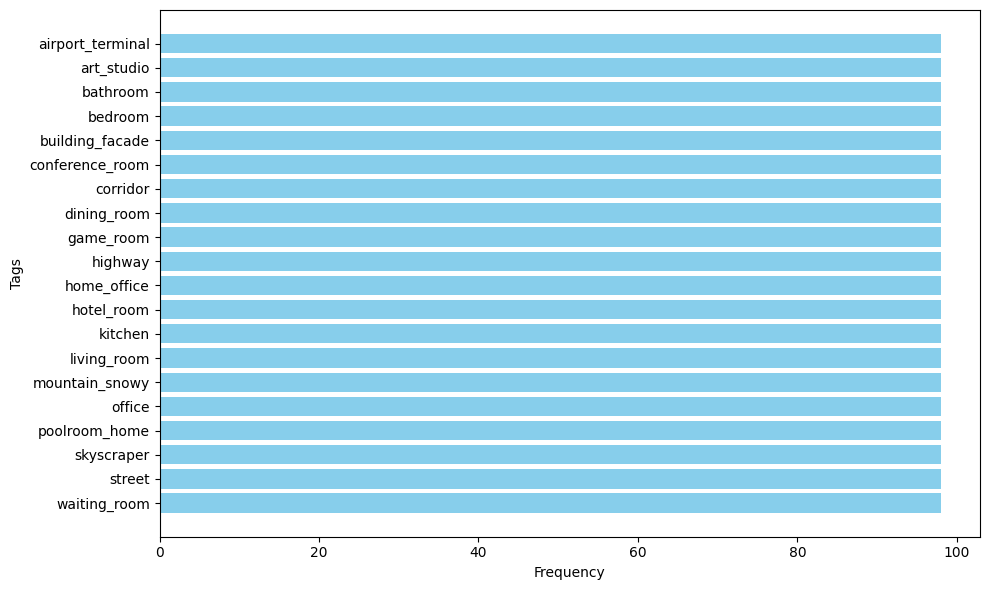

In [ ]:
# Create a horizontal bar plot
from collections import Counter

df_class = pd.read_csv('98_sampled_ade20k.csv')
df_class['list_tags'] = df_class.tags.str.split(" ")

# Count the frequency of each tag
tag_counts = Counter()
for tags in df_class['list_tags']:
    tag_counts.update(tags)

# Sort the tags by frequency in descending order
sorted_tag_counts = dict(sorted(tag_counts.items(), key=lambda item: item[1], reverse=True))

# Plotting
plt.figure(figsize=(10, 6))
for tag, count in sorted_tag_counts.items():
    plt.barh(tag, count, color='skyblue')

plt.xlabel('Frequency')
plt.ylabel('Tags')
# plt.title('Horizontal Histogram of Tags (Sorted by Frequency)')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.tight_layout()
plt.savefig('ade_undersamp_dist.pdf', format='pdf')
plt.show()

# # Count the frequency of each label
# label_counts = df_class['list_tags'].value_counts()

# # Exclude the label "misc"
# label_counts = label_counts[label_counts.index != 'misc']

# # Sort labels based on frequency in descending order
# sorted_labels = label_counts.sort_values().index


# plt.figure(figsize=(10, 6))
# plt.barh(sorted_labels, label_counts[sorted_labels], color='skyblue')
# plt.xlabel('Frequency')
# plt.ylabel('Labels')
# plt.title('Frequency of each label with cutoff at N=97 (descending order)')
# plt.tight_layout()


# # Show the plot
# plt.show()

### Training

In [ ]:
from torchvision import transforms as T, models
import torch.nn as nn

def get_model(weights=False, dropout_rate=0.2):
    model = nn.Sequential(
      nn.Linear(512, 128),
      nn.ReLU(inplace=True),
      nn.Dropout(dropout_rate),
      nn.Linear(128, 17),
      nn.Sigmoid()
    )

    return model.to(device)

In [ ]:
def train_batch(X, Y, model, loss_fn, optimizer, loss_scale=1):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X)
    batch_loss = 0

    # scale loss for classes with fewer images
    if loss_scale != 1:
      loss_per_item = loss_fn(Y_hat, Y)
      RARE_CLASSES = [ "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine" ]
      rare_classes_enc = torch.Tensor(transform_targets(RARE_CLASSES)).unsqueeze(0).to(device='cuda')
      rare_classes_enc = torch.tile(rare_classes_enc, dims=(Y.shape[0],1))
      mask = torch.tile((torch.sum(torch.logical_and(Y, rare_classes_enc), axis=1) > 0).unsqueeze(1), dims=(1,Y.shape[1]))
      scaled_loss = torch.where(mask, loss_per_item * loss_scale, loss_per_item)
      batch_loss = torch.mean(scaled_loss)
    # don't scale loss
    else:
      batch_loss = loss_fn(Y_hat, Y)

    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach().float().cpu().numpy()  # detach predictions from gradients for logging

    return Y_hat, batch_loss.item()

In [ ]:
@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss = torch.mean(batch_loss)
    Y_hat = Y_hat.float().cpu().numpy()

    return Y_hat, batch_loss.item()

In [ ]:
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import fbeta_score, confusion_matrix

from google.colab import files

def train_model(model, optimizer, loss_fn, dl_train, dl_val, epochs, filename, loss_scale):
    lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    loss_train, loss_val = [], []
    score_train, score_val = [], []

    Y_hat_val = None
    best_loss_val = np.inf

    for idx in range(epochs):
        loss_train_epoch, loss_val_epoch = [], []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer, loss_scale=loss_scale) # want to try 1.25, 1.5, 2, 2.5, 3?
            loss_train_epoch.append(batch_loss)
            Y_hat_train_epoch.extend(Y_hat)
            Y_train_epoch.extend(Y.detach().float().cpu().numpy())

        for X, Y in tqdm(dl_val, leave=False):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss_val_epoch.append(batch_loss)
            Y_hat_val_epoch.extend(Y_hat)
            Y_val_epoch.extend(Y.detach().float().cpu().numpy())

        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)

        Y_hat_train_epoch = np.array(Y_hat_train_epoch)
        Y_hat_val_epoch = np.array(Y_hat_val_epoch)
        Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
        Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
        Y_train_epoch = np.array(Y_train_epoch)
        Y_val_epoch = np.array(Y_val_epoch)

        score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
        score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")

        # saving values for debugging
        if avg_loss_val < best_loss_val:
            best_loss_val = avg_loss_val
            Y_hat_val = Y_hat_val_epoch
            Y_thresh_val = Y_thresh_val_epoch
            Y_val = Y_val_epoch

        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)
        score_train.append(score_train_epoch)
        score_val.append(score_val_epoch)

        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
        )

        # save checkpoint
        torch.save(model, filename + f'{idx+1}.pt')
        # pickle.dump(train_results, open(filename+'.results', "wb"))
        print(f'Saved model to {filename}.pt')
        # print(f'Saved results to {filename}.results')
        files.download(filename + f'{idx+1}.pt')

        lr_scheduler.step()

    train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }

    # torch.save(model, filename + '.pt')
    pickle.dump(train_results, open(filename+'.results', "wb"))
    # print(f'Saved model to {filename}.pt')
    print(f'Saved results to {filename}.results')
    files.download(f'{filename}.results')

In [ ]:
from torch.optim import Adam

# Set hyperparameters for batch size, epochs, learning rate
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 20
LOSS_SCALE = 1
filename = 'model'

# Load dataset in DataLoader
dl_train = DataLoader(
    ds_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=ds_train.collate_fn
)
dl_val = DataLoader(
    ds_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=ds_val.collate_fn
)

# Initialize model
model = get_model(False)
optimizer = Adam(model.parameters(), lr=LR)
loss_fn = nn.BCELoss(reduction='none') if LOSS_SCALE != 1 else nn.BCELoss()

# load from checkpoint
# model = torch.load('forest_clip_undersample_10.pt')

# Checkpoint file to save models + results
# Train
train_model(
    dl_train=dl_train,
    dl_val=dl_val,
    epochs=EPOCHS,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    filename=filename,
    loss_scale=LOSS_SCALE
    )

  0%|          | 0/4958 [00:00<?, ?it/s]

### Evaluation

In [ ]:
model = torch.load(filename + '20.pt')  # load best model
train_results = pickle.load(open(filename + '.results', "rb"))  # load best model results

In [ ]:
# Track loss and performance over time (for train and val)
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)
fig.show()

In [ ]:
Y_hat_val = np.array(train_results["Y_hat_val"])
Y_val = np.array(train_results["Y_val"])

pos_probas, neg_probas = [], []
for class_, idx in LABEL_IDXS.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
go.Figure([
    go.Bar(x=list(LABEL_IDXS), y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(LABEL_IDXS), y=neg_probas, name="Y_hat proba | Y = 0")
]).show()

In [ ]:
def find_best_thresholds(Y_hat, Y):
    """
    This is just a simple solution, but there are more rigorous ways to choose this threshold.
    """
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx

    global_best_score = fbeta_score(Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")

    return best_threshs

In [ ]:
threshs = find_best_thresholds(Y_hat_val, Y_val)

In [ ]:
# visualizes the confusion matrices
fig = make_subplots(cols=4, rows=5, subplot_titles=list(LABEL_IDXS.keys()))
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    ttl = np.sum(mat)
    col = jdx % 4+1
    row = jdx // 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {np.around(fn/ttl*100,2)}", f"tn: {np.around(tn/ttl*100,2)}"], [f"tp: {np.around(tp/ttl*100,2)}", f"fp: {np.around(fp/ttl*100,2)}"]],
            texttemplate="%{text}", colorscale='Viridis', name=list(LABEL_IDXS.keys())[jdx],
            hovertemplate=list(LABEL_IDXS.keys())[jdx],
            showscale=False
        ),
        col=col, row=row,
    )

    fig.update_yaxes(showticklabels=False, row=row, col=col)
    fig.update_xaxes(showticklabels=False, row=row, col=col)

fig.update_layout(
    width=1200, height=800, title="Confusion matrices",
)
fig.show()